# Bike Sharing Demand Forecast

Data source: https://www.kaggle.com/c/bike-sharing-demand/data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TODO: check & clean imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *

from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, classification_report, mean_squared_error

In [3]:
import itertools

## 1. Define Business Goal

Forecast bike demand given the data: datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed.

Example in words: Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?

## 2. Get Data

In [84]:
df = pd.read_csv("../data/bike-sharing-demand/train.csv")
df_kaggle_test = pd.read_csv("../data/bike-sharing-demand/test.csv")

In [85]:
# datetime format string doc: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
df_kaggle_test['datetime'] = pd.to_datetime(df_kaggle_test['datetime'], format="%Y-%m-%d %H:%M:%S")

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [87]:
df.set_index(keys='datetime', drop=False, inplace=True)
df_kaggle_test.set_index(keys='datetime', drop=False, inplace=True)

In [88]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

**count** is the sum of:
* **casual** - number of non-registered user rentals initiated
* **registered** - number of registered user rentals initiated

It belongs to our y data (target data), so we can omit it for now.

In [89]:
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [90]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
datetime,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


## 3. Tto_csvTest-Split

Define X and y:

* X : Training data
* y : Target values

In [91]:
df_full = pd.DataFrame(df) # keep a deep copy of unsplit data

In [92]:
y = df['count']
X = df.drop(['count'], axis=1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_test_kagggle = df_kaggle_test

## 4. Explore the Data

*(see other notebooks)*

In [94]:
# merge for exploration
df_train = X_train.join(other=y_train)
#df = df_train

## 5. Modelling
### 5.1 Feature engineering

#### Add time related features

* Day number since unix epoch (for implicit detrend of demand)
* Week day, hour, day of month  (one-hot-encoded and/or ordinal)

#### Additional features

* Interaction terms, Polynomial terms

#### Helpful material
* datetime docs: https://docs.python.org/3/library/datetime.html#datetime.datetime.timestamp
* datetime in pandas: https://towardsdatascience.com/working-with-datetime-in-pandas-dataframe-663f7af6c587

In [95]:
X_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,,
2011-07-11 00:00:00,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980
2012-05-18 22:00:00,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028
2011-04-01 23:00:00,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032
2012-09-16 09:00:00,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981
2011-02-01 23:00:00,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980


#### Considerations

* Hour, dayofweek, month -> numeric or one-hot-encoded ?
* Wheather -> num and/or one-hot ?

#### Further ideas

* StandardScaler after polynomial/interaction expansion
* Bin and one-hot-encode continuous variables like temperature.
* Introduce new one-hot-encoded time variable: Quarter of the day.
* Remove features and look at the impact.
* Hyperparameter optimization and evaluation
    * Other regression types (Ridge, ElasticNet)
    * Use *GridSearchCV*

In [96]:
def expand_to_hour(df):
    df.iloc[:,0] = df.iloc[:,0].dt.hour
    return df

def expand_to_dayofweek(df):
    df.iloc[:,0] = df.iloc[:,0].dt.dayofweek
    return df

def expand_to_month(df):
    df.iloc[:,0] = df.iloc[:,0].dt.month
    return df

def expand_to_quarter(df):
    df.iloc[:,0] = df.iloc[:,0].dt.quarter
    return df

def expand_to_year(df):
    df.iloc[:,0] = df.iloc[:,0].dt.year
    return df

def expand_to_timestamp(df, since="2000/01/01"):
    "Timestamp in days"
    timedelta = df.iloc[:,0] - pd.to_datetime(since)
    DAY_IN_SECONDS = 60*60*24
    df.iloc[:,0] = timedelta.dt.total_seconds()/(DAY_IN_SECONDS)
    return df

In [97]:
time_features_numerical_encoded = []
for expand_func in [expand_to_hour, expand_to_dayofweek, expand_to_month
                    ,expand_to_year, expand_to_quarter, expand_to_timestamp]:
    item = make_pipeline(FunctionTransformer(func=expand_func)
                         ,StandardScaler()) , ['datetime']
    time_features_numerical_encoded.append(list(item))

In [98]:
time_features_one_hot_encoded = [
    # Quarter of the day in one-hot-encoding
    [ make_pipeline(FunctionTransformer(func=expand_to_hour)
                    ,KBinsDiscretizer(n_bins=4, strategy='uniform'
                                       ,encode='onehot')), ['datetime'] ]
]
for expand_func in [expand_to_hour, expand_to_dayofweek, expand_to_month
                    ,expand_to_year, expand_to_quarter]:
    item = make_pipeline(FunctionTransformer(func=expand_func)
                         ,OneHotEncoder(sparse=False)) , ['datetime']
    time_features_one_hot_encoded.append(list(item))

In [99]:
physical_continuous_features = [[ StandardScaler() , ['windspeed', 'humidity', 'temp', 'atemp'] ]]
day_category_features = [[ OneHotEncoder(sparse=False) , ['workingday', 'holiday'] ]]

wheather_feature_numerical = [[ StandardScaler() , ['weather'] ]]
wheather_feature_ohe = [[ OneHotEncoder(sparse=False) , ['weather'] ]]

season_feature_numerical = [[ StandardScaler() , ['season'] ]]
season_feature_ohe = [[ OneHotEncoder(sparse=False) , ['season'] ]]

In [100]:
all_feature_sets = [
    time_features_numerical_encoded
    ,time_features_one_hot_encoded
    ,physical_continuous_features
    ,day_category_features
    ,wheather_feature_numerical
    ,wheather_feature_ohe
    ,season_feature_numerical
    ,season_feature_ohe
]
all_features = []
[all_features.extend(features) for features in all_feature_sets]
column_transformer = make_column_transformer(*all_features)

Todo: Try different combinations of `all_feature_sets` with the help of `itertools.combinations()`

In [101]:
transformer = make_pipeline( column_transformer
                            ,PolynomialFeatures(degree=2) )
#transformer = column_transformer # override PolynomialFeatures
transformer

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function expand_to_hour at 0x7fb49613c790>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['datetime']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function expand_to_dayofweek at...
                                                   'temp', 'atemp']),
                                                 ('onehotencoder-1',
          

In [102]:
transformer.fit(X_train)
X_train_tf = transformer.transform(X_train)
X_test_tf  = transformer.transform(X_test)
X_test_kagggle_tf = transformer.transform(X_test_kagggle)
X_train_tf.shape, X_test_tf.shape, X_test_kagggle_tf.shape

((8164, 3081), (2722, 3081), (6493, 3081))

### 5.2 Train model and evaluate

In [23]:
elastic_net_m = ElasticNet()

In [24]:
elastic_net_m.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [25]:
hyperparams = {
    'alpha': [0.2],#[0.2,0.4,0.6,0.8,1.0,1.25,1.5],#np.linspace(0,1,21),
    'l1_ratio': [1.0]#[0.3,0.7,1.0]#np.linspace(0,1,11)
}

In [26]:
m = GridSearchCV(estimator=elastic_net_m, param_grid=hyperparams, cv=5, scoring='r2') 

In [27]:
m.fit(X_train_tf, y_train)

/Users/raphael/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38256.862380150706, tolerance: 21518.38130457816
  model = cd_fast.enet_coordinate_descent(
/Users/raphael/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30172.80919307284, tolerance: 21169.110850528257
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.2], 'l1_ratio': [1.0]}, scoring='r2')

In [103]:
m.best_params_

{'alpha': 0.2, 'l1_ratio': 1.0}

Inspect coefficients

In [104]:
print("Show features that got selected by regularization (# are non-zero coeffs):")
_tol = 0.01
for coef in m.best_estimator_.coef_:
    print("#" if coef > _tol else "_", end=' ')

Show features that got selected by regularization (# are non-zero coeffs):
_ # _ # _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # _ _ _ _ # _ _ _ # _ _ _ _ _ # # _ _ _ # _ _ _ _ _ # _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ # _ # # # _ _ _ _ _ _ _ # # _ # _ _ _ _ _ _ _ _ # # _ _ _ _ _ _ _ _ _ _ _ # _ _ _ # _ _ _ _ _ _ # _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ # _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ # # # # _ _ _ _ _ # # _ # _ _ _ # # _ _ _ _ _ _ _ _ _ _ _ _ _ # # _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # _ _ _ _ _ _

In [105]:
y_pred_test = m.predict(X_test_tf)
y_pred_train = m.predict(X_train_tf)

<AxesSubplot:ylabel='Count'>

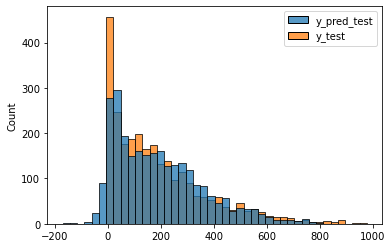

In [106]:
y_pred_test
sns.histplot(data=pd.DataFrame({'y_pred_test':y_pred_test, 'y_test':y_test}))

Distribution looks fine. Negative demand has to be clamped to zero in the post.

In [107]:
m.score(X_train_tf, y_train)

0.9241412411156844

In [108]:
r2_score(y_train, y_pred_train)

0.9241412411156844

In [109]:
r2_score(y_test, y_pred_test)

0.9174593215839656

In [110]:
print('MSE:'
      , mean_squared_error(y_train, m.predict(X_train_tf))
      , mean_squared_error(y_test, m.predict(X_test_tf)))

MSE: 2488.837266579428 2708.4931310652582


In [111]:
m.cv_results_['mean_test_score'][m.best_index_]

0.9162558808762581

No signs of overfitting so far.

### Kagggle

In [112]:
y_pred_kaggle = m.predict(X_test_kagggle_tf)

In [113]:
# clip negative predictions
y_pred_kaggle_clipped = y_pred_kaggle.clip(min=0, max=None)

In [114]:
df_kaggle_test.shape, y_pred_kaggle_clipped.shape

((6493, 9), (6493,))

In [115]:
df_kaggle_test['count'] = y_pred_kaggle_clipped

In [116]:
df_kaggle_submission = pd.DataFrame(df_kaggle_test[['count']])
df_kaggle_submission.head()

,count
datetime,
2011-01-20 00:00:00,25.896953
2011-01-20 01:00:00,2.073450
2011-01-20 02:00:00,0.000000
2011-01-20 03:00:00,0.000000
2011-01-20 04:00:00,0.000000


In [117]:
df_kaggle_submission.to_csv('kaggle_submission_lasso_alpha_0.2.csv', sep=',')